# Group18 Final Project
## App Market Analysis: Apple Store and Google Play Store
- Group Member: Shiying Wang, Ruochen Zhong, Qing Gao


## Introduction
When you want to download an App on your iphone, most of you may look through some reviews, especially that App is paid. Do you prefer to look 5 star reviews or 1 star reviews? Which one is helpful for you? After you get clear about all of its strength and drawbacks. You decide to pay $4.99 and download it. You feel it is good, but when your friend who use Samsung tells you he download it by free, you become angry soon. How could this happen? They are a same app ! My friend use Android mobile phone, he prefer same apps as me, but for all Ios and Android customers, Are their preference the same? Where are those developers living? If they address is close to me, I need to knock their door and tell them to update soon because this app cannot fill my new iphone XS plus’s screen...... People use mobile phone so frequently, and this lead to many interesting questions. In this project, we focus on finding the answer of those interesting questions to you.

## Focus:
1. User Preference for Both market
    - How is the popularity of our dataset in the markets?
    - What is distribution of rating, category, price, content rating,etc.?
    - What is the bivariate relationship between features?  
2. User Review
   - What would people tend to say in thier reviews?
   - Can we find some common compliments/complain from reviews? 
   - How many words people usually say over different rating?
   - Can we detect the sentiment of user reviews?
3. Market Comparison
   - What are developers located in the U.S.?
   - Is the Apps in two markets performs similar?  
4. Prediction
   - Can we use sentiment analysis score to predict rating of that review?
   - Can we predict overall rating based on other uncorrelated features?

## Method
1. Data Extraction
    - 4 data sources including 2 scraped data.
2. Data Cleaning
3. Visualization
    - Box Plot/Bar Plot/Pie Chart, etc.
    - Heatmap/Word Cloud/Sankey Diagram/Folium Map/Radar Chart
4. Machine Learning
    - Sentiment Analysis
    - Linear Regression/Logistic Regression/Random Forest

In [1]:
import pandas as pd
import numpy as np
import warnings
import re

import requests
import play_scraper
import time

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from uszipcode import SearchEngine
import folium


import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
import statsmodels.formula.api as sm

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#nltk.downloader.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
warnings.filterwarnings("ignore")

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Data Extraction and Munging

### Apple Store Data

####  Apple Data Cleaning
We first download apple dataset from a [kaggles dataset](https://www.kaggle.com/ramamet4/app-store-apple-data-set-10k-apps). 
- data_apple: Apple datasets from Kaggles

In [2]:
#1. Data Extraction and Munging
#1.1 Apple Store Data
#1.1.1 Apple Data Cleaning

#read the data, and description of apps
data_apple = pd.read_csv('../data/AppleStore.csv')
des_apple = pd.read_csv('../data/appleStore_description.csv') 

#drop unrelated columns, rename column name , fill 'Source' and 'Type', add description to each app
data_apple.drop(['Unnamed: 0', 'currency','vpp_lic'], axis=1, inplace=True)
data_apple.columns.values[[1,2,3,6,8,9,10]] = ['Name','Size','Price','Rating','Version','Content_Rating','Category']
data_apple['Size'] = data_apple['Size']/(1024*1024)
data_apple['Source'] = "Apple"
data_apple['Type'] = data_apple['Price'].apply(lambda x: 'Paid' if x > 0 else 'Free')
data_apple = pd.merge(data_apple, des_apple[['id','app_desc']], on='id')
data_apple['id'] = data_apple['id'].astype('str')
data_apple.head(2)

,id,Name,Size,Price,rating_count_tot,rating_count_ver,Rating,user_rating_ver,Version,Content_Rating,Category,sup_devices.num,ipadSc_urls.num,lang.num,Source,Type,app_desc
0,281656475,PAC-MAN Premium,96.119141,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,Apple,Paid,"SAVE 20%, now only $3.99 for a limited time!\n..."
1,281796108,Evernote - stay organized,151.232422,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,Apple,Free,Let Evernote change the way you organize your ...


#### Apple Data Scrapping
We are also intrested what people would say in thier App reviews. We expected to get some useful positive and negative feedback. From the user feedbacks, developers can evaluate thier App and understand what they should keep, avoid and make change or improvement. 

Since Apple only release top 50 reviews by review categories, for each App, we scraped 50 most helpful reviews which defined by iTunes. Note that some App does not have any review.
- apple_review: Scraped review of app in Apple from the iTunes RSS Genearator API.

In [4]:
#1.1.2 Apple Data Cleaning
#App scraping function
def apple_review(js):
    """
    Scrape the reviews from iTunes' review api and append to given lists
    -----
    Argument:
        js: Get Json file
        url: Url of the link.
    """
    try:
        var = js['feed']['entry']
        for i in range(len(var)):
            appid.append(re.search('id=(.+)/s', url).group(1))
            title.append(var[i]['title']['label'])
            rating.append(var[i]['im:rating']['label'])
            review.append(var[i]['content']['label'])
    except KeyError:
        return None

In [7]:
#create new lists for storing data
appid = []
title = []
rating = []
review = []

In [8]:
#scarpping review data
for i in data_apple.id[0:7197]:
    url = 'https://itunes.apple.com/rss/customerreviews/id={}/sortBy=mostHelpful/json'.format(i)
    req = requests.get(url)
    js = req.json()
    apple_review(js)

In [9]:
#save the file to local
cols = ['appid','title','rating','review']
df = pd.DataFrame(list(zip(appid,title,rating,review)), columns = cols)
#converting dataframe into csv
#df.to_csv('../data/apple_review.csv',encoding='utf_8_sig')

In [19]:
#reload the itunes review from prior saved data
review_apple = pd.read_csv('../data/apple_review.csv',low_memory=False)
review_apple = review_apple.drop('Unnamed: 0', 1)
review_apple.head(2)

,appid,title,rating,review
0,281796108.0,Come back in - the water is fine,5.0,Having been a long time and premium user of Ev...
1,281796108.0,Customer Service,1.0,If you are looking for a company that has acce...


#### Apple Data of User Review
We tried the sentitment analysis for user review using existing pacakge in order to predict the rating in the further step. We are also curious about the relationship between word length and user rating. The dataset for Apple review has the features of sentiment analysis for both title and review, and the word length for each title and review.

In [4]:
#1.1.3 Apple Data Sentiment Analysis
#original data of apple review
review_apple = pd.read_csv('../data/apple_review.csv')
# drop NA
review_apple.dropna(subset=['title'], inplace=True)
review_apple = review_apple.reset_index(drop = True)
# create two new columns 
review_apple['Title Compound'] = 0
review_apple['Review Compound'] = 0

In [ ]:
#do sentiment analysis, and saved it to a new csv file apple_review2
#nltk.downloader.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
for i in range(apple_review.shape[0]):
    apple_review['Title Compound'].iloc[i] = sid.polarity_scores(apple_review['title'][i])['compound']
    apple_review['Review Compound'].iloc[i] = sid.polarity_scores(apple_review['review'][i])['compound']
review_apple.to_csv('apple_review2.csv')

- apple_review2: add sentiment analysis, title length, and review length based on review_apple

In [5]:
#get apple_review2 with sentiment analysis
apple_review2 = pd.read_csv('../data/apple_review2.csv')
apple_review2 = apple_review2.drop('Unnamed: 0', 1)
apple_review2.rename(columns={'Title Compound': 'title_comp','Review Compound':'review_comp'}, inplace=True)
apple_review2.drop_duplicates(['review'],inplace = True)
apple_review2 = apple_review2[(apple_review2['title_comp'] != 0) | (apple_review2['review_comp'] != 0)]

# Calculate the word length
apple_review2['title length'] = apple_review2['title'].str.split()
apple_review2['title length'] = apple_review2['title length'].apply(len)

apple_review2['review length'] = apple_review2['review'].str.split()
apple_review2['review length'] = apple_review2['review length'].apply(len)

apple_review2.head(2)

,appid,title,rating,review,title_comp,review_comp,title length,review length
0,281796108.0,Come back in - the water is fine,5.0,Having been a long time and premium user of Ev...,0.2023,0.7690,8,248
1,281796108.0,Customer Service,1.0,If you are looking for a company that has acce...,0.0000,0.9892,2,247


### Google Play Data
We first download apple dataset from a [kaggles dataset](https://www.kaggle.com/lava18/google-play-store-apps). However, this dataset only has a small fraction overlap with our Apple dataset, so we scrape more App information using [`play-scraper`](https://pypi.org/project/play-scraper/) based on the name of Apple. 

#### Google Play Data Scrapping

In [96]:
#1.2 Google Play Data
#1.2.1 Google Play Data Scrapping

#creating empty lists to store data
Name = []
Appid = []
Rating =[]
sc_num = []
Price = []
Reviews = []
Description = []
Category = []
Version = []
Size = []
Update_time = []
Installs = []
Content_rating = []
Req_ver = []
Edit_choice = []
IAP = []
IAP_range = []
Rate_hist = []
developer_address=[]
iosname = []

In [ ]:
#scrape App information from google play store based on Apple dataset
def android_app(name):
    '''
    Scrape App information from google play store
    -----
    Argument:
        name: input name in the search engine 
    '''
    search = play_scraper.search(name)
    try:
        app = play_scraper.details(search[0]['app_id'])
        Name.append(app['title'])
        Appid.append(app['app_id'])
        Rating.append(app['score'])
        sc_num.append(len(app['screenshots']))
        Price.append(app['price'])
        Reviews.append(app['reviews'])
        Description.append(app['description'])
        Category.append(app['category'])
        Version.append(app['current_version'])
        Size.append(app['size'])
        Update_time.append(app['updated'])
        Installs.append(app['installs'])
        Content_rating.append(app['content_rating'])
        Req_ver.append(app['required_android_version'])
        Edit_choice.append(app['editors_choice'])
        IAP.append(app['iap'])
        IAP_range.append(app['iap_range'])
        Rate_hist.append(app['histogram'])
        developer_address.append(app['developer_address'])
        iosname.append(name)
    except:
        return None

In [ ]:
#data scraping
start_time = time.time()
for names in data_apple.Name:
    android_app(names)
    time.sleep(0.1)
print(time.time() -start_time)

In [97]:
#store data into dataframe
cols_a= ['Name','Appid','Rating','sc_num','Price','Reviews','Description'\
        ,'Category','Version','Size','Update_time','Installs'\
        ,'Content_rating','Req_ver','Edit_choice','IAP','IAP_range'\
        ,'Rate_hist','developer_address','iosname']

df_a = pd.DataFrame(list(zip(Name,Appid,Rating,sc_num,Price,Reviews,Description\
        ,Category,Version,Size,Update_time,Installs\
        ,Content_rating,Req_ver,Edit_choice,IAP,IAP_range\
        ,Rate_hist,developer_address,iosname)), columns = cols_a)
#converting dataframe into csv
#df_a.to_csv('../data/new_android.csv',encoding='utf_8_sig')

- data_android2: data scrapped based on the name of the data_apple dataset

In [6]:
#reload the dataset: scraped data based on names in Apple datasets
data_android2 = pd.read_csv('../data/new_android.csv')
data_android2.head(2)

,Unnamed: 0,Name,iosname,name_similarity,Appid,Rating,sc_num,Price,Reviews,Description,...,Size,Update_time,Installs,Content_rating,Req_ver,Edit_choice,IAP,IAP_range,Rate_hist,developer_address
0,0,PAC-MAN Championship Edition DX,PAC-MAN Premium,0.434783,com.bandainamcoent.pacmancedx,4.5,6,$1.99,1816,New Price – For a Limited Time Only!\nGet read...,...,36M,"April 23, 2018","10,000+",['Everyone'],4.0.3 and up,False,False,NaN,"{5: 1347, 4: 251, 3: 83, 2: 36, 1: 99}","2051 Mission College Blvd., Santa Clara, CA 9..."
1,1,Evernote,Evernote - stay organized,0.484848,com.evernote,4.5,21,0,1497796,Evernote helps you focus on what matters most ...,...,Varies with device,"December 1, 2018","100,000,000+",['Everyone'],5.0 and up,True,True,"('$1.00', '$99.99')","{5: 1071594, 4: 295588, 3: 58942, 2: 21822, 1:...","305 Walnut Street\nRedwood City, CA 94063"


#### Google Play Data Cleaning

In [8]:
#function for data cleaning
def covert_size(size):
    '''
    convert the android size to MB
    -----
    Argument:
        size: original string size
    Output:
        size in MB
    '''
    if size == 'Varies with device':
        return np.nan
    elif size.endswith('M'):
        size = size[:-1]
        return float(size)
    elif size.endswith('K'):
        size = size[:-1]
        return float(size)/0.001
    
def compare(str1,str2):
    '''
    compare the name of Apple and Android, check whether thier first words are the same 
    -----
    Argument:
        str1: input compared string
        str2: input compared string
    Output:
        True: thier first words are the same
        False: thier first words are not the same 
    '''
    a = re.split(r"[\W']+",str1.lower())
    b = re.split(r"[\W']+",str2.lower())
    if a[0]==b[0]:
        return True
    else:
        return False

- data_android1: Google play store datasets from Kaggles

In [9]:
#data_android1
data_android1 = pd.read_csv('../data/googleplaystore.csv')
#remove row with error 
data_android1.drop(index = 10472,inplace = True)
#assign column names
data_android1.columns =['Name', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type',\
       'Price', 'Content_rating', 'Genres', 'Update_time', 'Version',\
       'Req_ver']
#change price to numeric
data_android1['Price'] = data_android1['Price'].apply(lambda x: float(x.strip('$')))
#clean size
data_android1['Size'] = data_android1['Size'].apply(covert_size)

- data_android2: Scraped data based on names in Apple datasets

In [10]:
#data_android2
data_android2 = pd.read_csv('../data/new_android.csv')
data_android2 = data_android2.drop('Unnamed: 0', 1)  
data_android2['name_similarity'] = [compare(data_android2.Name[i],data_android2.iosname[i])\
                                    for i in range(len(data_android2))]
#clean category and match to data_android1
data_android2.Category = data_android2.Category.apply(lambda x: re.split(r"[\W']+",x)[1])
game_cat = data_android2[data_android2.Category.str.contains('GAME')==True].Category.unique()
data_android2.Category.replace(game_cat,'GAME',inplace=True)
#match content rating to data_android1
data_android2.Content_rating=data_android2.Content_rating.apply(lambda x: re.split(r"[\W']+",x)[1]\
                                                                +' '+re.split(r"[\W']+",x)[2]+'+' \
                                   if (re.split(r"[\W']+",x)[2]=='10' or re.split(r"[\W']+",x)[2]=='17')\
                                                                else re.split(r"[\W']+",x)[1])
#clean prices data
data_android2['IAP'] = data_android2['IAP'].apply(lambda x: 'Paid' if x == True else 'Free')
data_android2['Price'] = data_android2['Price'].apply(lambda x: float(x.strip('$')))
data_android2['Type'] = data_android2['Price'].apply(lambda x: 'Paid' if x > 0 else 'Free')
#clean size
data_android2['Size'] = data_android2['Size'].apply(covert_size)
data_android2.shape

(4950, 22)

- data_android: Combine both Google play data sources for Android Market analysis

In [11]:
#combine both google play data sources
data_android = pd.concat([data_android1, data_android2], join='inner')
data_android.drop_duplicates(['Name'],inplace = True)

data_android['Type'] = data_android['Price'].apply(lambda x: 'Paid' if x > 0 else 'Free')
#claen variable formats
data_android['Installs'] = data_android['Installs'].apply(lambda x: float(x.replace(',','').strip('+')))
data_android['Reviews'] = data_android.Reviews.astype('float')
data_android['Update_time'] = pd.to_datetime(data_android['Update_time'], format='%B %d, %Y')
data_android['Category'] = data_android['Category'].str.replace('_',' ').str.title()
#match content rating
data_android['Content_rating'] = data_android['Content_rating'].replace('Adults only 18+','Mature 17+')
data_android['Content_rating'] = data_android['Content_rating'].apply(lambda x: np.nan if x =='Unrated' else x)
data_android.rename(columns={'Content_rating': 'Content_Rating'}, inplace=True)
data_android.head(2)

,Name,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Update_time,Version,Req_ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,Art And Design,4.1,159.0,19.0,10000.0,Free,0.0,Everyone,2018-01-07,1.0.0,4.0.3 and up
1,Coloring book moana,Art And Design,3.9,967.0,14.0,500000.0,Free,0.0,Everyone,2018-01-15,2.0.0,4.0.3 and up


### Combination of Markets

#### Data for Market Comparison
Merge the dataset based on the exactly same name.

- comp: combination of apple/android datasets by same App name

In [12]:
# extract some specific variable from data_android2 
comp = data_android2[['Name','iosname','Price','Size',
                            'Version','Rating','Type','Description','developer_address']]
# rename some variable 
comp = comp.rename({'Price':'Andro_price',
                                'Size':'Andro_size',
                                'Version':'Andro_version',
                                'Rating':'Andro_rating',
                                'Type':'Andro_type',
                                'Description':'Andro_description',
                                'Name': 'Andro_name',
                                'iosname':'Name'
                                }, axis='columns')
# combine it with those variables in data_apple
comp = pd.merge(comp, data_apple[['Name','Price','Category','Content_Rating',
                                              'Size','Version','Rating','Type','app_desc']], on=['Name'])
# rename new variables 
comp = comp.rename({'Price':'ios_price',
                                'Size':'ios_size',
                                'Version':'ios_version',
                                'Rating':'ios_rating',
                                'Type':'ios_type',
                                'app_desc':'Ios_description',
                                'Name':'ios_name'
                                }, axis='columns')
# change the order of the column 
comp = comp[['developer_address','Andro_name','ios_name','Category','Content_Rating',\
                         'Andro_price','ios_price','Andro_size','ios_size',\
                         'Andro_version','ios_version','Andro_rating','ios_rating',\
                         'Andro_type','ios_type','Andro_description','Ios_description']]
# choose those observations with the same name 
comp = comp[comp['Andro_name'] == comp['ios_name']]

comp.shape

(1547, 17)

In [13]:
# round the rating of android based on the 0.5 
def round_number(x, base):
    return base * round(float(x)/base)

comp['Price_Consistency'] = comp['Andro_price'] == comp['ios_price']
comp = comp.dropna(subset=['Andro_rating'])
comp['Andro_rating'] = comp['Andro_rating'].apply(lambda x: round_number(x, base=.5))
comp = comp.reset_index(drop = True)
comp.shape

(1540, 18)

## Focus 1. User Preference

App users shows various preference when choosing and reviewing to an App. The user preferences demonstrate that which category of app is the most popular one, how prices of apps are distributed, what is trend for rating based on categories, how content rating (age range) varies with rating, and etc.

### 1.1 Popularity of Apps
Our dataset of Google Play represents a small portion of the whole Google Play data. To better understand our dataset in the google play market, we look at the overall installs to get a sense of the popularity of the APPs. From the Statistics, 75 percentile of the Apps have more than 1 million installs, half of them have more than one hundred thousand installs and 25 percentile have more than 5,000 installs. This indicates that more than half of the APPs in the datastes are very popular. 

In [35]:
data_android.Installs.describe()

count    1.392500e+04
mean     6.293277e+06
std      4.539043e+07
min      0.000000e+00
25%      5.000000e+03
50%      1.000000e+05
75%      1.000000e+06
max      1.000000e+09
Name: Installs, dtype: float64

Since Apple does not release the number of installs in order to encourage new developer, we cannot see the popularity of the dataset.

### 1.2 Rating Distribution

- Apple Store: 

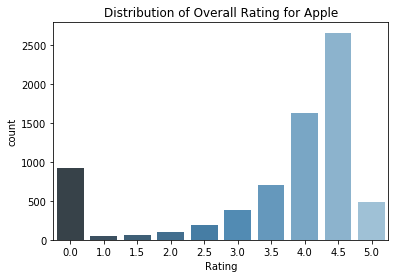

In [36]:
#Apple Store
sns.countplot(x='Rating',data = data_apple,palette="Blues_d")
plt.title('Distribution of Overall Rating for Apple')
plt.show()

The original datasets rounded the rating as gap of 0.5. However, we can still see that the majority of the rating in the range of 3.5 to 4.5 in the Apple Store. Also, the number of extreme rating (1, 5) is relatively small/ Also, our Apple dataset contains some unpopular or new Apps, so the rating is shown as 0. The graph shows that our datasets contais about 1000 of such Apps. 

- Google Play: 

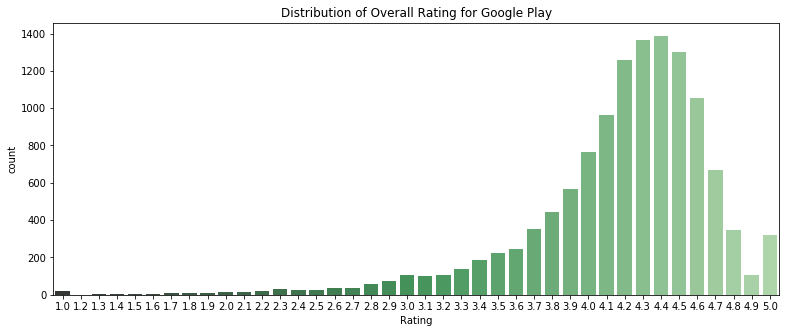

In [19]:
#google play
plt.figure(figsize=(13,5))
sns.countplot(x='Rating',data = data_android,palette="Greens_d")
plt.title('Distribution of Overall Rating for Google Play')
plt.show()

The rating data of Google play stores is more specific. In the dataset of Google Play, most APPs are high rating which are concentrated between 4.1 and 4.6, and thier most frequent rating is also around 4.5. The number of extreme rating is relatively small as well.

### 1.3 Category DistributionCategory Distribution

In [19]:
def percentage(data, k):
    """combine the least k% of categories into one category 'Other'
       separte the free and paid application into two lists
    """
    category = pd.crosstab(data.Category, data.Type)
    category['Number'] = category['Free'] + category['Paid'] 
    other_name = []
    for i in range(len(category)):
        if category['Number'][i] <= k*sum(category['Number']):
            other_name.append(category.index.values[i])
            category.index.values[i] = "Other"
        
    category = category.groupby(category.index).sum().sort_values(by='Number',ascending=False)
    category = category.rename(index={'Other': "Other: "+", ".join(other_name)})
    
    free = category['Free'].values.tolist()
    paid = category['Paid'].values.tolist()
    total  = category['Number'].values.tolist()
    price_list = [j for i in zip(free,paid) for j in i]

    return category, price_list

- Apple Store

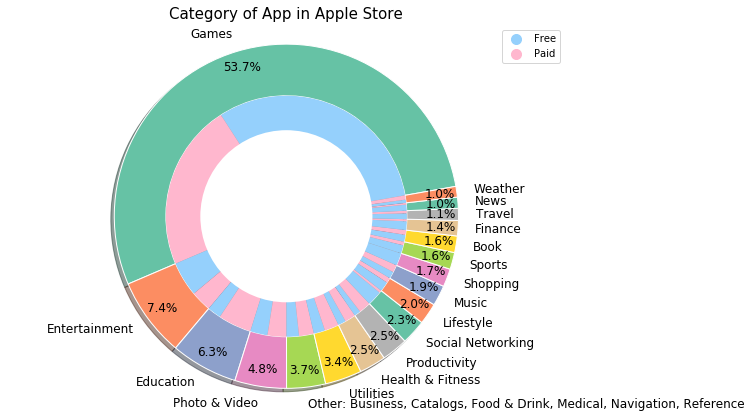

In [20]:
#Apple
category_apple = percentage(data_apple,0.01)[0]
price_apple = percentage(data_apple,0.01)[1]
color_inner = ['xkcd:light blue','xkcd:baby pink'] * len(category_apple)
colors = ['xkcd:light blue','xkcd:baby pink']
label_price = ["Free","Paid"]

size = 0.3
plt.figure(figsize=(10,7))
sns.set_palette("Set2",plt.cm.tab20c.N )
plt.pie(category_apple.Number, labels=category_apple.index, radius=1, startangle=10, autopct='%.1f%%',
        shadow = True, pctdistance=0.9, wedgeprops=dict(width=size, edgecolor='w'),
       textprops={'fontsize': 12})
plt.pie(price_apple, radius=1-size, startangle=10, colors = color_inner,
         shadow = True, pctdistance=0.8)
patches = [ plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=colors[i], 
            label="{:s}".format(label_price[i]) )[0]  for i in range(len(label_price)) ]
plt.legend(handles=patches, loc='upper right', ncol=1, facecolor="white", numpoints=1)
plt.title('Category of App in Apple Store',fontsize=15)
centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=0)

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')
plt.show()


As the pie chart shown, catrgory of Games are more than half of the dataset. After research, this might because Apple's API have more open data with Games category. The major categories are "Games", "Entertainment" and "Educaton". For the inner circle, the number of free app is only slightly larger than the number of paid app. 

- Google Play

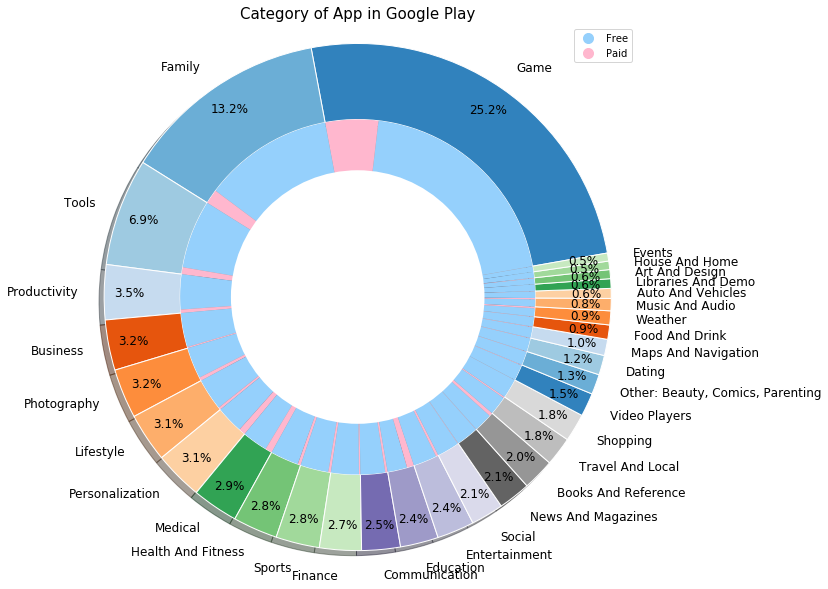

In [21]:
#Google Play
category_android = percentage(data_android,0.005)[0]
price_android = percentage(data_android,0.005)[1]
price_color = ['xkcd:light blue','xkcd:baby pink'] * len(category_apple)
price_index = ["Free","Paid"] * len(category_android)

size = 0.3
plt.figure(figsize=(10,10))
sns.set_palette("tab20c",plt.cm.tab20c.N )
plt.pie(category_android.Number, labels=category_android.index, radius=1, startangle=10, autopct='%.1f%%',
        shadow = True, pctdistance=0.90, wedgeprops=dict(width=size, edgecolor='w'),
       textprops={'fontsize': 12})
plt.pie(price_android, radius=1-size, startangle=10, colors = price_color,
         shadow = True, pctdistance=0.80)
patches = [ plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=colors[i], 
            label="{:s}".format(label_price[i]) )[0]  for i in range(len(label_price)) ]
plt.legend(handles=patches, loc='upper right', ncol=1, facecolor="white", numpoints=1)
plt.title('Category of App in Google Play',fontsize=15)
centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=0)

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')
plt.show()

The category in Google Play store is more diversed. The major categories are "Game", "Family" and "Tools". For the inner circle, the number of free app is much larger than the number of paid app. From the above pie charts, we can see that the major of the category in both markets is game. However, the two markets show huge difference in the proportion of free app. We did further exploration based on such inconsistency.

### Price Distribution 

- Apple Store: interquartile of price is [1.99, 4.99]

In [23]:
apple_paid = data_apple[data_apple.Type == 'Paid']
pd.DataFrame(apple_paid.Price.describe())

,Price
count,3141.000000
mean,3.955298
std,8.315882
min,0.990000
25%,1.990000
50%,2.990000
75%,4.990000
max,299.990000


- Google Play: interquartile of price is [1.99, 4.99]

In [24]:
and_paid = data_android[data_android.Type == 'Paid']
pd.DataFrame(and_paid.Price.describe())

,Price
count,1637.000000
mean,8.532028
std,40.321031
min,0.990000
25%,1.990000
50%,2.990000
75%,4.990000
max,400.000000


The interquartile of both markets are [1.99,4.99]. Apparently Apple store has more paid App then Google play store. However, the price mean and standard deviation of Google play store are much larger than Apple store. To find the reason, we explore the price range in different categories.  

### Boxplot for Price Distribution of Category

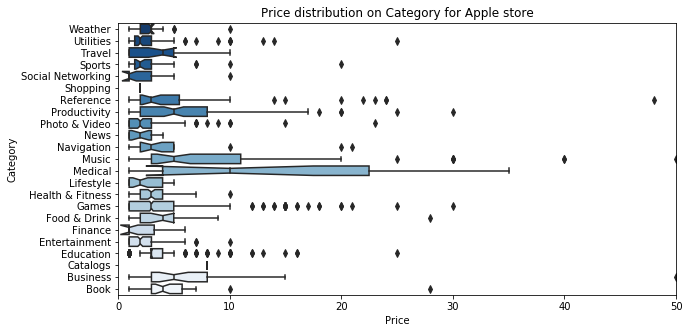

In [45]:
#Apple
plt.figure(figsize=(10,5))
price = data_apple[['Category','Price']].loc[data_apple['Type']=="Paid"]

order = price.groupby(by=["Category"])["Price"].mean().iloc[::-1].index

sns.boxplot(x="Price", y="Category", data=price,
            notch=True, order=order,
            palette="Blues_r").set_xlim([0,50])
plt.title('Price distribution on Category for Apple store')
plt.show()

From the Boxplot of Apple store, we can see that medical has the most spreaded distribution. We looked into top 4 most expensive applications in the medical category, and we find that those Apps are designed as 3D model for Anatomy, and most of them have relatively large size. Beside the one only has 125 megabyte, which only recive 1 person to rate and the low rating.

In [26]:
data_apple[data_apple.Category == 'Medical'].nlargest(4,'Price')

,id,Name,Size,Price,rating_count_tot,rating_count_ver,Rating,user_rating_ver,Version,Content_Rating,Category,sup_devices.num,ipadSc_urls.num,lang.num,Source,Type,app_desc
3012,920133658,Anatomy & Physiology: Body Structures and Func...,1677.223633,34.99,49,14,4.5,4.0,4.1.11,12+,Medical,37,5,5,Apple,Paid,This app is available in 5 languages. Tap the ...
866,446207961,Human Anatomy Atlas – 3D Anatomical Model of t...,1251.289062,24.99,1298,144,4.5,4.5,8.0.27,12+,Medical,38,5,7,Apple,Paid,Note: There is a more robust version of this p...
1754,593042008,teamLabBody-3D Motion Human Anatomy-,125.233398,24.99,1,1,1.0,1.0,3.0.4,12+,Medical,38,5,2,Apple,Paid,SALE!\n\nteamLabBody-3D Motion Human Anatomy- ...
6212,1117998129,Human Anatomy Atlas 2017 - Complete 3D Human Body,934.563477,24.99,73,19,4.5,5.0,2017.3.35,12+,Medical,25,5,7,Apple,Paid,The all-new Human Anatomy Atlas 2017 Edition i...


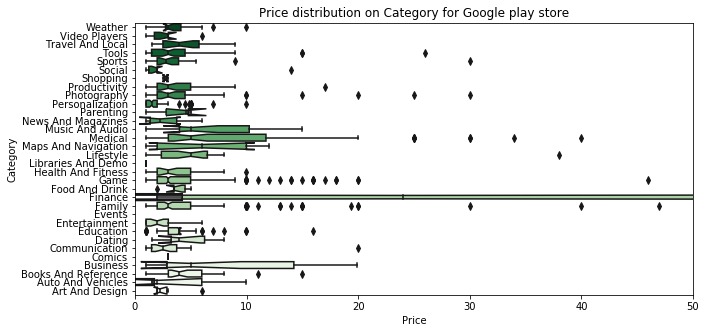

In [49]:
#Google Play
plt.figure(figsize=(10,5))
price2 = data_android[['Category','Price']].loc[data_android['Type']=="Paid"]

order = price2.groupby(by=["Category"])["Price"].mean().iloc[::-1].index

sns.boxplot(x="Price", y="Category", data=price2,
            notch=True, order=order,
            palette="Greens_r").set_xlim([0,50])
plt.title('Price distribution on Category for Google play store')
plt.show()

From the boxplot of Google play store, we can see that the category of Finance has an extremly long box. We again looked into the top 4 most expensive application in Finance. The result shows that all of them are joking Apps, 'I am rich'. Those App has only small sizes and low versions but super expensive prices. From this analysis, we can see that Apple store might have more strick policy for App development approval or policy for price setting than Google play store. 

In [51]:
data_android[data_android.Category == 'Finance'].nlargest(4,'Price')

,Name,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Update_time,Version,Req_ver
5356,I Am Rich Premium,Finance,4.1,1867.0,4.7,50000.0,Paid,399.99,Everyone,2017-11-12,1.6,4.0 and up
5358,I am Rich!,Finance,3.8,93.0,22.0,1000.0,Paid,399.99,Everyone,2017-12-11,1.0,4.1 and up
5359,I am rich(premium),Finance,3.5,472.0,NaN,5000.0,Paid,399.99,Everyone,2017-05-01,3.4,4.4 and up
5364,I am rich (Most expensive app),Finance,4.1,129.0,2.7,1000.0,Paid,399.99,Teen,2017-12-06,2,4.0.3 and up


### Bar Chart for Related Variables to Category (Rating, Size, Price)

- Apple Store

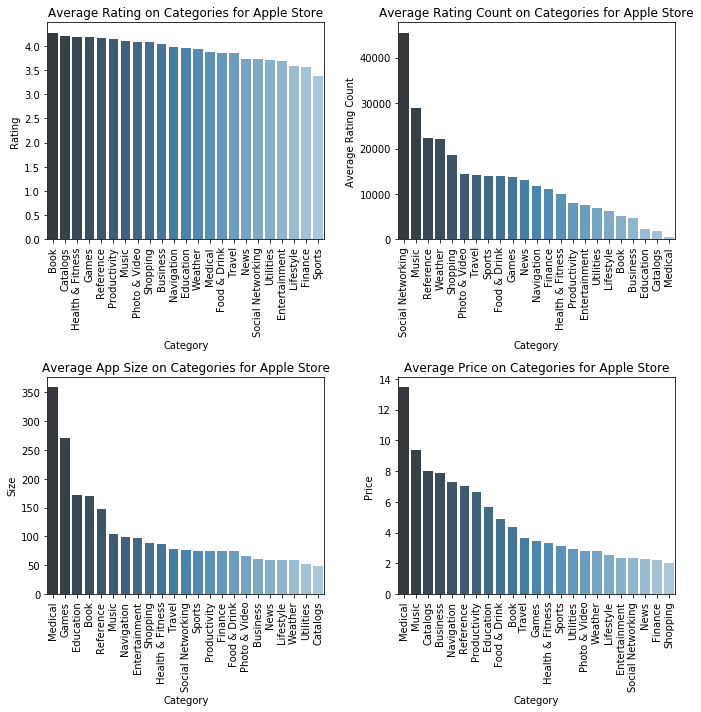

In [52]:
#Apple Store
fig, ((axis1,axis3),(axis2,axis4)) = plt.subplots(2,2,figsize=(10,10))
# category vs. average rating
cat_rat = pd.DataFrame(data_apple[data_apple.Rating != 0\
                    ].groupby('Category').mean()['Rating'].sort_values(ascending=False)).reset_index()
sns.barplot(x="Category", y='Rating', data=cat_rat,palette='Blues_d',ax=axis1)
axis1.set(title = 'Average Rating on Categories for Apple Store')
axis1.set_xticklabels(axis1.get_xticklabels(),rotation=90)
#category vs. average rating count
cat_ratcount = pd.DataFrame(data_apple.groupby('Category'\
                                ).mean()['rating_count_tot'].sort_values(ascending=False)).reset_index()
sns.barplot(x="Category", y='rating_count_tot', data=cat_ratcount,palette='Blues_d',ax=axis3)
axis3.set(ylabel = 'Average Rating Count',title = 'Average Rating Count on Categories for Apple Store')
axis3.set_xticklabels(axis3.get_xticklabels(),rotation=90)
#category vs. average size
cat_size = pd.DataFrame(data_apple.groupby('Category').mean()['Size'].sort_values(ascending=False)).reset_index()
sns.barplot(x="Category", y='Size', data=cat_size,palette='Blues_d',ax=axis2)
axis2.set(title = 'Average App Size on Categories for Apple Store')
axis2.set_xticklabels(axis2.get_xticklabels(),rotation=90)
#category vs. average price
cat_price = pd.DataFrame(data_apple[data_apple.Type == 'Paid'\
                            ].groupby('Category').mean()['Price'].sort_values(ascending=False)).reset_index()
sns.barplot(x="Category", y='Price', data=cat_price,palette='Blues_d',ax=axis4)
axis4.set(title = 'Average Price on Categories for Apple Store')
axis4.set_xticklabels(axis4.get_xticklabels(),rotation=90)

plt.tight_layout()
plt.show()

1. Excluded App with no rating, the rating are quite similiar in different categories. While the differences are very small, Book category has the highest average rating and Sports category has the lowest average rating.
2. The bar plot of average rating count shows that Apple users are more likely to comment on Social Networking category. This might because the social networking applications in our dataset are usually very popular, e.g. Facebook, which explains why does this category has the most average comment.
3. (and 4) The bar plot of average APP size and average price show that Medical has the highest average size and price while the Games category is second higherst average size. We have looked at it above: Most of the big size and expensive Medical Apps are 3D anatomy structcture Applications.

- Google Play

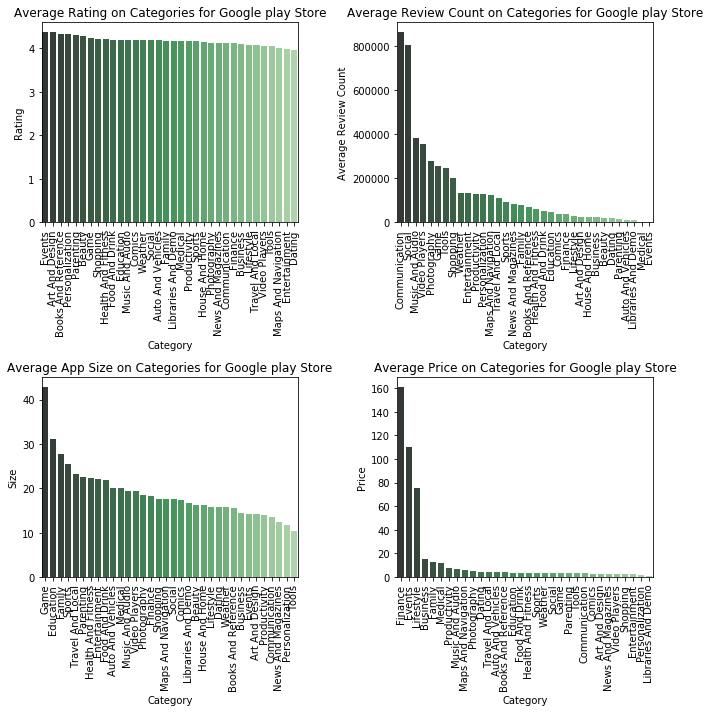

In [53]:
#Google Play Store
fig, ((axis1,axis3),(axis2,axis4)) = plt.subplots(2,2,figsize=(10,10))
# category vs. average rating
cat_rat1 = pd.DataFrame(data_android.groupby('Category').mean()['Rating'].sort_values(ascending=False)).reset_index()
sns.barplot(x="Category", y='Rating', data=cat_rat1,palette='Greens_d',ax=axis1)
axis1.set(title = 'Average Rating on Categories for Google play Store')
axis1.set_xticklabels(axis1.get_xticklabels(),rotation=90)
#category vs. average review count
cat_revcount = pd.DataFrame(data_android.groupby('Category'\
                                        ).mean()['Reviews'].sort_values(ascending=False)).reset_index()
sns.barplot(x="Category", y='Reviews', data=cat_revcount,palette='Greens_d',ax=axis3)
axis3.set(ylabel = 'Average Review Count',title = 'Average Review Count on Categories for Google play Store')
axis3.set_xticklabels(axis3.get_xticklabels(),rotation=90)
#category vs. average size
cat_size1 = pd.DataFrame(data_android.groupby('Category').mean()['Size'].sort_values(ascending=False)).reset_index()
sns.barplot(x="Category", y='Size', data=cat_size1,palette='Greens_d',ax=axis2)
axis2.set(title = 'Average App Size on Categories for Google play Store')
axis2.set_xticklabels(axis2.get_xticklabels(),rotation=90)
#category vs. average price
cat_price1 = pd.DataFrame(data_android[data_android.Type == 'Paid'\
                    ].groupby('Category').mean()['Price'].sort_values(ascending=False)).reset_index()
sns.barplot(x="Category", y='Price', data=cat_price1,palette='Greens_d',ax=axis4)
axis4.set(title = 'Average Price on Categories for Google play Store')
axis4.set_xticklabels(axis4.get_xticklabels(),rotation=90)

plt.tight_layout()
plt.show()

1. From the bar plot of average rating, we can see that the rating are high and very similiar in different categories. While the differences are very small, Events category has the highest average rating and Dating category has the lowest average rating.
2. Similiar with Apple market, Communication and social category have the most average review. After briefly looking at the data, we get the same explaination as Apple market which is those App are much popular than others.
3. The bar plot of average App size shows that the Games category has the biggest average App size. Furthermore, the overall size distribution in Google Play store is smaller than Apple store. The reason is that phones with android systerm are varies. The APP size in the Android market is only like a zip file with maximum 100 megabytes , while the real size is larger than what it was shown in the Google play store page.
4. The bar plot of average price show that the most expensive categories are finance,events lifestyle. After looking at the dataset, the categories of Finance and Lifestyle contains many joking Apps like 'I am rich', while category of  Events only has one paid App which is $109. Beside these three categories, the overall prices are more normal.

### Content Rating

- Apple Store

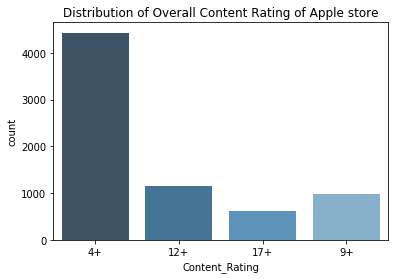

In [54]:
sns.countplot(x='Content_Rating',data = data_apple,palette="Blues_d")
plt.title('Distribution of Overall Content Rating of Apple store')
plt.show()

In Apple store, most Apps has content rating of 4+, this indicates that most Apps do not have age limited. 

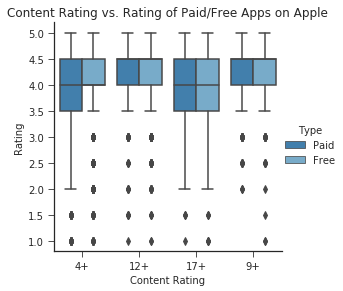

In [60]:
with sns.axes_style(style='ticks'):
    g = sns.factorplot("Content_Rating", "Rating", "Type", data=data_apple[data_apple.Rating != 0], kind="box")
    g.set_axis_labels("Content Rating", "Rating");
    g.set(title = 'Content Rating vs. Rating of Paid/Free Apps on Apple')

The boxplots show the range of Content rating on Rating for both Paid and Free APPs in Apple store. After removed the no rating Apps, The range of Paid Apps and Free Apps are similiar. For content rating 4+, Paid App has wider range of rating. Also, content rating of 17+ for both Free and Paid Apps has wider rating. This indicates that people tend to rate more harsh on Paid APPs and 'adult Apps'.

- Google Play

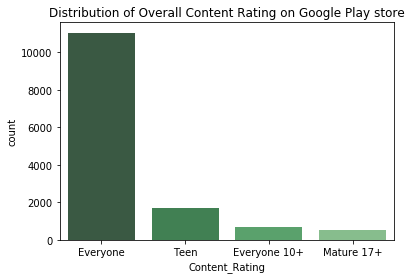

In [61]:
sns.countplot(x='Content_Rating',data = data_android,palette="Greens_d")
plt.title('Distribution of Overall Content Rating on Google Play store')
plt.show()

Similiar with Apple store, most Apps focus on everyone in the Google play store market.

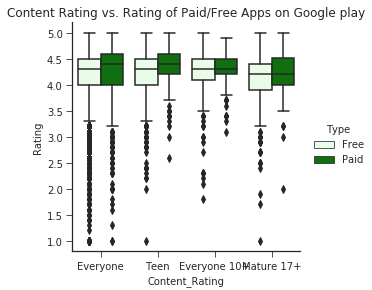

In [62]:
with sns.axes_style(style='ticks'):
    g = sns.factorplot("Content_Rating", "Rating", "Type", data=data_android, kind="box",color='Green')
    g.set_axis_labels("Content_Rating", "Rating");
    g.set(title = 'Content Rating vs. Rating of Paid/Free Apps on Google play')

From the boxplot of Content rating on Rating for both Paid and Free APPs on Google play store, we can see that Paid Aps recive slightly better average rating range than Free Apps. This is different with Apple store. Furthermore, the rating range of Mature 17+ is slightly worse than others. 

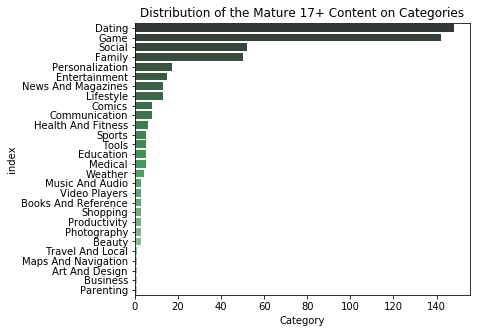

In [63]:
matu17_cat = data_android[data_android.Content_Rating == \
                          'Mature 17+'].Category.value_counts().reset_index(drop=False)
plt.figure(figsize=(6,5))
sns.barplot(y=matu17_cat.iloc[:,0],x=matu17_cat.iloc[:,1],data = data_android,palette="Greens_d")
plt.title('Distribution of the Mature 17+ Content on Categories')
plt.show()

From the barplot, we can see that most of Mature 17+ are from Dating and Game category. Dating category has only small portion of the dataset, and from the above barplot of average rating on category, we know that Dating category has the lowest average rating. Thus the relatively low rating are more likely from the Dating category. 

## Focus 2. User Review

In [64]:
# get two mask of apple logo shape and android logo shape
mask_apple = np.array(Image.open('applelogo.jpg'))
mask_android = np.array(Image.open('androidlogo.jpg'))

### Word Cloud For the 1 Star Reviews in Apple store

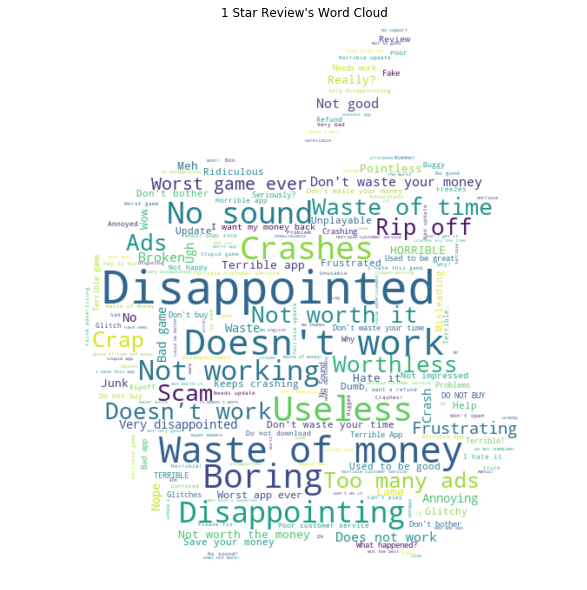

In [66]:
#subset rating 1 group
rating1 = apple_review2[apple_review2['rating']==1]

mask_apple = np.array(Image.open('applelogo.jpg'))
# find those most frequent words
title_freq1 = dict(rating1.title.value_counts())
# remove some useless words
keys_to_remove = ['Terrible','Horrible','Bad','Awful','Garbage','Stupid','Trash']
for k in keys_to_remove:
    try:
        del title_freq1[k]
    except KeyError:
        pass
    
# draw the wordcloud
wcloud = WordCloud(mask = mask_apple, background_color ="white").generate_from_frequencies(title_freq1)
plt.figure(figsize=(10,10))
plt.imshow(wcloud, interpolation="bilinear")
plt.title("1 star Review's Word Cloud")
plt.axis("off")
plt.show()

From this 1 star wordcloud, we can see that after we filter out words like "Terrible", "Horrible","Bad"..... We can find some major complains such as "not interesting", "Waste of time and money","Many ads", "Bugs, Crashes, Rip off, Scam", "No sound". 

### Word Cloud For the 5 Star Reviews in Apple store

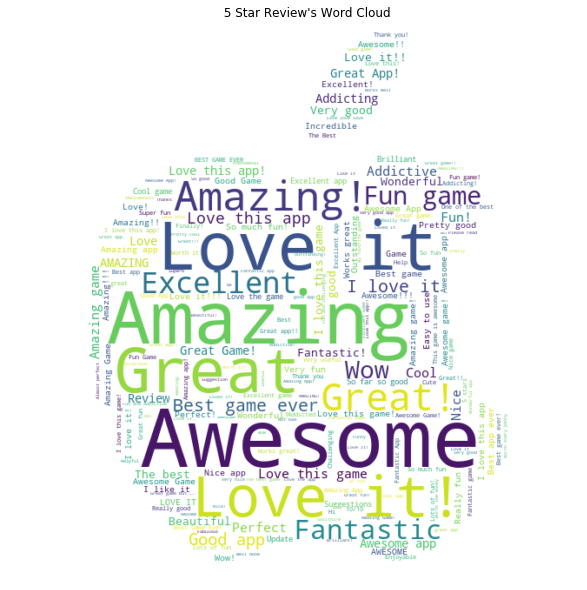

In [67]:
# subset 5 stars rating group
rating5 = apple_review2[apple_review2['rating']==5]
# find those most frequent words and filter out some useless words
title_freq5 = dict(rating5.title.value_counts())
keys_to_remove = ['Awesome game','Great game','Great app','Fun',
                  'Good','Great App','Awesome!','Great app!','Great game!',
                  'Great Game','Good game']
for k in keys_to_remove:
    try:
        del title_freq5[k]
    except KeyError:
        pass
# draw the word cloud 
wcloud = WordCloud(mask = mask_apple, background_color ="white").generate_from_frequencies(title_freq5)
plt.figure(figsize=(10,10))
plt.imshow(wcloud, interpolation="bilinear")
plt.title(" 5 score Review's Word Cloud")
plt.axis("off")
plt.show()

For this 5 star word cloud, although we have already filtered out some positive words, there are still a lot of similar praises in this wordcloud. It didn't give us too much useful infromation.

### Word Length

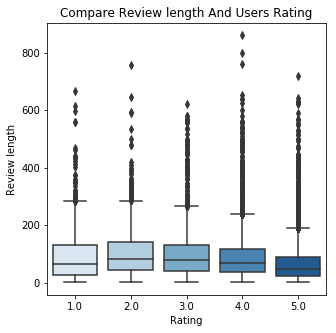

In [68]:
# compare them by the boxplot
plt.figure(figsize=(5,5))
sns.boxplot(x="rating", y="review length", data=apple_review2,palette='Blues')
plt.title('Compare Review length And Users Rating')
plt.ylabel('Review length')
plt.xlabel('Rating')
plt.show()

#### Summary of Word Length 

In [69]:
# show each group's median
apple_review2.groupby(apple_review2.rating)[['review length']].median()

,review length
rating,
1.0,65
2.0,83
3.0,79
4.0,69
5.0,48


Combining the boxplot and the median comparison of those 5 rating groups.We can find that for those people who give 5 stars, they tend to type less words. We think this is because they are very satisfied and don’t have too much suggestions to give. For people who give less stars, they say relatively more contents. This means those people tend to give more suggestions in their review.

## Focus 3. Market Comparison

### Map

In [11]:
comp_add = comp.copy()
# a new dataset to focus on developer's address
comp_add = comp_add[['developer_address','Andro_name']]
comp_add.dropna(subset=['developer_address'], inplace=True)

# extract zip code from the variable developer address
comp_add['length'] = comp_add['developer_address'].str.split()
comp_add['zip'] = comp_add['length'].str[-1]
comp_add = comp_add[comp_add.zip.apply(lambda x: x.isnumeric())]
comp_add = comp_add.loc[comp_add['zip'].str.len() == 5]
comp_add = comp_add.reset_index(drop = True)

# trandform those zipcode to longitude and latitude
search = SearchEngine(simple_zipcode=True)
comp_add['long'] = 0
comp_add['lat'] = 0

for i in range(comp_add.shape[0]):
     zipcode = search.by_zipcode(comp_add['zip'][i])
     comp_add['lat'].iloc[i] = zipcode.values()[7]
     comp_add['long'].iloc[i] = zipcode.values()[8]

# drop some NA values 
comp_add = comp_add.dropna(subset=['lat'])
comp_add = comp_add.dropna(subset=['long'])

comp_add.head()


,developer_address,Andro_name,length,zip,long,lat
0,"2051 Mission College Blvd., Santa Clara, CA 9...",Ms. PAC-MAN,"[2051, Mission, College, Blvd.,, Santa, Clara,...",95054,-121.96,37.40
1,"1 Hacker Way\nMenlo Park, CA 94025",Facebook,"[1, Hacker, Way, Menlo, Park,, CA, 94025]",94025,-122.18,37.46
2,"90 Corona St #1301\nDenver, CO 80218",Cleartune - Chromatic Tuner,"[90, Corona, St, #1301, Denver,, CO, 80218]",80218,-104.97,39.73
3,"39252 Winchester Rd. Murrieta, CA 92563",Period Tracker Deluxe,"[39252, Winchester, Rd., Murrieta,, CA, 92563]",92563,-117.13,33.59
4,"2051 Mission College Blvd., Santa Clara, CA 9...",PAC-MAN,"[2051, Mission, College, Blvd.,, Santa, Clara,...",95054,-121.96,37.40


In [14]:
#make an empty map
m = folium.Map(location=[39.50, -98.35], zoom_start= 4)
#add marker one by one on the map
for i in range(comp_add.shape[0]):
  folium.Marker([comp_add['lat'].iloc[i], comp_add['long'].iloc[i]], popup=comp_add['Andro_name'].iloc[i]).add_to(m)
#display it 
m

Here is a example of the graph produced by above code:
![](../img/map.gif)

for these apps released in both market in our dataset, we can see that most of their developer's address are concentrate on those big citys. From this map, we can see that in Westcoast, most of them distributed in Seattle, Sanfrancisco, and LosAngeles. In the middle of the US, there are many in the Dallas. In the Eastcoast, most of them are distributed in Miami and NewYork.

###  Difference in Price

In [79]:
# compare those with different price in two markets
diff_price = comp[comp['Price_Consistency'] == False]
# drop some values 
diff_price = diff_price.dropna(subset=['Andro_rating'])
diff_price = diff_price[diff_price.ios_rating != 0]
diff_price = diff_price.reset_index(drop = True)

(307, 20)

#### In one free, but another paid 

In [80]:
#for those in android is free, but in IOS is paid
len(diff_price[diff_price['Andro_price'] == 0])

132

In [81]:
#for those in IOS is free, but in android is paid 
len(diff_price[diff_price['ios_price'] == 0]) 

5

#### Both paid but have different price

In [82]:
# subset those apps both paid in two markets but price different 
diff_price2 = diff_price[(diff_price['Andro_price'] != 0)&(diff_price['ios_price'] != 0)]
len(diff_price2)

170

In [84]:
#both paid, but android is cheaper 
len(diff_price2[diff_price['Andro_price'] < diff_price['ios_price']])

72

In [85]:
# create two subset to check each group's number of observation
andro_free = diff_price[diff_price['Andro_price'] == 0]
ios_free = diff_price[diff_price['ios_price'] == 0]

andro_free = andro_free.rename({'Andro_name':'Name'}, axis='columns')

#study why so much in android is free but in iso is paid
why_androfree= pd.merge(andro_free[['Name']], data_android2[['Name','IAP']], on=['Name'])
why_androfree['IAP'].value_counts()

Paid    96
Free    36
Name: IAP, dtype: int64

### Sankey Diagram

In [15]:
# draw a sankey diagram based on the number and logic development 
plotly.tools.set_credentials_file(username='fsywang', api_key='mvdttmYzHesovKxfRjAE')

data = dict(
    type='sankey',
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(
        color = "black",
        width = 0.5
      ),
      label = ["Total observation of different prices", "One free but another paid",
               "Both paid but price different","Android free but Ios paid", 
               "Ios free but Android paid","Android more expensive", "Ios more expensive", 
               "Android In-App-Purchase True", "Android In-App-Purchase False","In-App-Purchase False"],
      color = ["blue", "yellow", "red", "yellow", "yellow", "red","red","yellow","yellow","blue"]
    ),
    link = dict(
      source = [0,0,1,1,2,2,2,3,3,2],
      target = [1,2,3,4,5,6,3,7,8,3],
      value = [137,170,132,5,98,72,0,96,36,0]
  ))

layout =  dict(
    title = "Analysis of those who have diffrent prices in two Markets",
    font = dict(
      size = 10
    )
)

fig = dict(data=[data], layout=layout)
py.iplot(fig, validate=False)

Here is a example of the graph produced by above code:
![](../img/sankey_diagram.gif)

From this diagram, we can find that there is a huge difference in number when one is free but another is paid. For those in Android free but iOS paid, there are 132 observations, but for those in iOS free but Android paid, there are only 5. we continue to study and find that for those 132 observations, ¾ of them have In-App-Purchase. We guess that maybe in android market. App developers are more willing to set free download of their app at first in Android market than in iOS market to attract customers, and use other methods like in-app-purchase to make profits.

### Rating

In [16]:
# subset a data to compare those with different rating
diff_rating = comp[comp['Andro_rating'] != comp['ios_rating']]
# drop some NA and 0 values 
diff_rating = diff_rating.dropna(subset=['Andro_rating'])
diff_rating = diff_rating[diff_rating.ios_rating != 0]
diff_rating = diff_rating.reset_index(drop = True)
diff_rating.shape

(712, 18)

In [17]:
#assign interval to rating values 
diff_rating['interval_an']=pd.cut(diff_rating['Andro_rating'], 
          bins=[-1,2,2.5,3.5,4.5,5],labels=["[0, 2]","(2, 2.5]","(2.5, 3.5]","(3.5, 4.5]","(4.5, 5]"])
diff_rating['interval_io']=pd.cut(diff_rating['ios_rating'], 
          bins=[-1,2,2.5,3.5,4.5,5],labels=["[0, 2]","(2, 2.5]","(2.5, 3.5]","(3.5, 4.5]","(4.5, 5]"])
#group by those intervals 
rating_comp1 = diff_rating.groupby(['interval_an']).size().reset_index(name='count')
rating_comp2 = diff_rating.groupby(['interval_io']).size().reset_index(name='count')

In [18]:
# draw a Radar chart to show App's rating distribution in each interval 
plotly.tools.set_credentials_file(username='fsywang', api_key='mvdttmYzHesovKxfRjAE')

data = [
    go.Scatterpolar(
      r = rating_comp1['count'],
      theta = rating_comp1['interval_an'],
      fill = 'toself',
      name = 'AndroRating'
    ),
    go.Scatterpolar(
      r = rating_comp2['count'],
      theta = rating_comp2['interval_io'],
      fill = 'toself',
      name = 'IOSRating'
    )
]

layout = go.Layout(
  polar = dict(
    radialaxis = dict(
      visible = True,
      range = [0, 600]
    )
  ),
  showlegend = False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, validate=False)


Here is a example of the graph produced by above code:

![](../img/radar_plot.png)

From this plot, The orange one reflects the IOS rating and the blue one reflects the Android rating.We can see that for those Apps released in both market, when they have different prices, most of their android prices tend to concentrate on the interval of 3.5 to 4.5, but for IOS market, their rating tend to be distributed more in all other intervals. We think this shows that customer in Android Market are more willing to give a relatively neutral or positve rating for an app, but in IOS market, those ratings tend to distributed more in other ranges.

## Focus 4. Prediction
We try to see if we can predict rating based other non-rating related features. Since it is hard to do the multiclassification because of the low correlation, we convert the problem to a binary case based on whether the App is successful on rating. We define that if the App has rating greater than 4, it is successful on rating, otherwise it's not.

### Part I: Predict by Sentiment Analysis 
- We did sentiment analysis for apple_review2 Dataset

In [6]:
apple_review2.head(5)

,appid,title,rating,review,title_comp,review_comp,title length,review length
0,281796108.0,Come back in - the water is fine,5.0,Having been a long time and premium user of Ev...,0.2023,0.7690,8,248
1,281796108.0,Customer Service,1.0,If you are looking for a company that has acce...,0.0000,0.9892,2,247
2,281796108.0,Lost photos I uploaded for recipes,1.0,I used to love Evernote until today. I bragged...,-0.3182,-0.9513,6,250
3,281796108.0,No customer service,2.0,So I've been using Evernote for over three yea...,-0.2960,0.7014,3,208
4,281796108.0,It’s a great tool,5.0,It’s a great tool for various different reason...,0.6249,0.9223,4,179


In [8]:
# fit a linear regression of rating by title and review sentiment
rating_ols = sm.ols(formula = "rating ~ title_comp + review_comp", data=apple_review2).fit()
# print the R-squared 
print('R-square is equal to : ', rating_ols.rsquared)

R-square is equal to :  0.3511516559043135


We fit a linear regression model of rating by sentiment of title and review.

Our model is : rating ~ title_comp + review_comp.

The R-square of this regression is 0.351. After fitting the model, we used the fitted value to predict the rating, and the result is:

In [97]:
# using those predicted parameter to predict rating
apple_review2["Pre_rating"] = rating_ols.params[0] + rating_ols.params[1]*apple_review2["title_comp"] + rating_ols.params[2]*apple_review2["review_comp"]
# round the predicted rating to nearest 1 
apple_review2["Pre_rating"] = apple_review2["Pre_rating"].apply(lambda x: round_number(x, base=1))
apple_review2.head(5)

,appid,title,rating,review,title_comp,review_comp,title length,review length,Pre_rating
0,281796108.0,Come back in - the water is fine,5.0,Having been a long time and premium user of Ev...,0.2023,0.7690,8,248,4
1,281796108.0,Customer Service,1.0,If you are looking for a company that has acce...,0.0000,0.9892,2,247,4
2,281796108.0,Lost photos I uploaded for recipes,1.0,I used to love Evernote until today. I bragged...,-0.3182,-0.9513,6,250,2
3,281796108.0,No customer service,2.0,So I've been using Evernote for over three yea...,-0.2960,0.7014,3,208,3
4,281796108.0,It’s a great tool,5.0,It’s a great tool for various different reason...,0.6249,0.9223,4,179,5


In [98]:
# check the accuracy of the prediction
apple_review3 = apple_review2[apple_review2["Pre_rating"] == apple_review2["rating"]]
accuracy = len(apple_review3)/len(apple_review2)
accuracy

0.3472100448699615

In [7]:
nltk.downloader.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
sent1 = sid.polarity_scores('I love it.')['compound']
sent2 = sid.polarity_scores('I dislike it recently.')['compound']
sent3 = sid.polarity_scores('I love it. However I dislike it recently.')['compound']
sent4 = sid.polarity_scores('I dislike it. However I like it recently')['compound']
print(sent1, sent2, sent3, sent4)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/little/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
0.6369 -0.3818 0.3818 -0.0258


We use the sentiemnt score we get to predict the rating of each rows. However, the accuracy of our prediction is only 0.34, a very low rate. Why causes this?

We did further exploration about the sentiment analysis. We think the main reason is that our package to decide the sentiment analysis is not accurate when if deal with long sentences. When those sentences have some turning point such as 'however', 'although', 'but', that package cannot give a very accurate decision of that sentiment. For example, the sentiment of the sentence "I love it" is 0.64, while the sentiment of the sentence "I love it. However I dislike it recently" is 0.38 which should be negative sentiment for this sentence. Thus, our sentiment score of the review is not accurate.

### Part II: Predict Rating By Other Vairiables
- Variables in the original kaggle datasets

In [99]:
def cat_rate(rating):
    '''
    Convert the rating to a binary case \n
    high rating is greater than 4, and low rating is equal or smaller than 4
    -----
    Argument: 
        rating: rating of the APP
    Output:
        1: high rating Apps
        0: low rating Apps
    '''
    if rating > 4:
        return 1
    else:
        return 0

- Apple store:

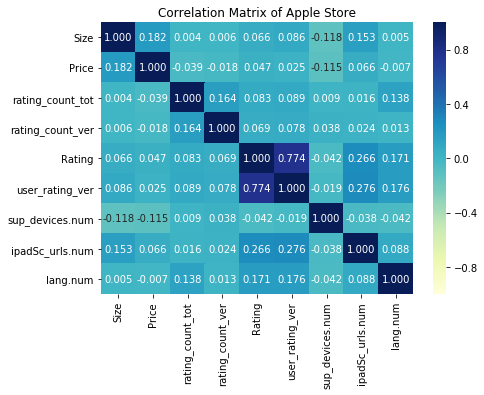

In [100]:
#plot correlation matrix for Apple store
plt.figure(figsize=(7,5))
sns.heatmap(data_apple.corr(), vmin=-1, vmax=1, annot=True, fmt=".3f",cmap="YlGnBu")
plt.title('Correlation Matrix of Apple Store')
plt.show()

From the correlation matrix, we can see that there is no correlation between rating and other features beside the current version rating. However, we could not use current version rating since the overall rating is also depend on the current version rating. 
Using the 10 folds cross validation, we did the transformation with random forest classifier and compare it with logistic regression. The logistic regression recieve 61% of accuracy and Random forest recieve 65% of accuracy. The test score of random forest has only increased 4%. However, the training score of random forest is 98% which is close to 1. This indicates our random forest classifier is overfitting.

In [101]:
warnings.filterwarnings("ignore")
#create a subset for apple data
pre_ios = data_apple
pre_ios['cat_rating']=pre_ios.Rating.apply(lambda x: cat_rate(x))
pre_ios = pd.concat([pre_ios.iloc[:,2:5],pre_ios.iloc[:,9:18]], axis=1, sort=False)
pre_ios = pre_ios.dropna()
pre_ios = pre_ios.drop(['Source','app_desc'],axis=1)
#factorize the strings to fit the model
pre_ios['Content_Rating'] = pd.factorize(pre_ios['Content_Rating'])[0]
pre_ios['Category'] = pd.factorize(pre_ios['Category'])[0]
pre_ios['Type'] = pd.factorize(pre_ios['Type'])[0]
#assign X and y
X_ios = pre_ios.iloc[:,:9]
y_ios = pre_ios['cat_rating']
#used model
models = [LogisticRegression(),RandomForestClassifier()]
#create empty data frame
acc_ios = pd.DataFrame(columns=['Model','train_score','test_score'])
#doing cross validation for both model and put them into dataframe
for i,model in enumerate(models):
    cv_results = cross_validate(model, X_ios, y_ios, cv=10, scoring='accuracy')
    acc_ios.loc[i, 'Model'] = model.__class__.__name__
    acc_ios.loc[i, 'train_score'] = cv_results['train_score'].mean()
    acc_ios.loc[i, 'test_score'] = cv_results['test_score'].mean()
acc_ios

,Model,train_score,test_score
0,LogisticRegression,0.615195,0.610258
1,RandomForestClassifier,0.982585,0.653503


- Google Play store:

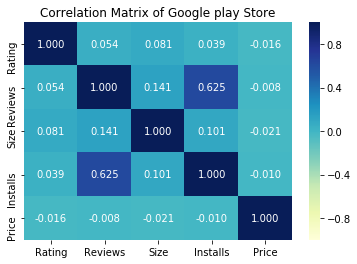

In [102]:
#plot correlation matrix for google play store
sns.heatmap(data_android.corr(), vmin=-1, vmax=1, annot=True, fmt=".3f",cmap="YlGnBu")
plt.title('Correlation Matrix of Google play Store')
plt.show()

From the correlation martix plot of Google play store, we can see that there is no correlation between rating and other features. We use the same prediction methods as above, but we find that the test score for both classifier are similiar, around 64% accuracy. Furthermore, random forest still has the overfitting problem.
<br>
In conclusion of prediction, because the features are uncorelated, the rating is hard to predict based on those features.  

In [103]:
#create a subset for apple data
pre_and = data_android
pre_and['cat_rating']=pre_and.Rating.apply(lambda x: cat_rate(x))
pre_and = pd.concat([pre_and['Category'], pre_and.iloc[:,3:]], axis=1, sort=False)
pre_and= pre_and.dropna()
#factorize the strings to fit the model
pre_and['Category'] = pd.factorize(pre_and['Category'])[0]
pre_and['Content_Rating'] = pd.factorize(pre_and['Content_Rating'])[0]
pre_and['Type']= pd.factorize(pre_and['Type'])[0]
#drop unused columns
pre_and=pre_and.drop(['Update_time','Version','Req_ver'],axis=1)
#assign X and y
X_and = pre_and.iloc[:,:7]
y_and =pre_and['cat_rating']
#create empty dataframe
acc_and = pd.DataFrame(columns=['Model','train_score','test_score'])
#doing cross validation for both model and put them into dataframe
for i,model in enumerate(models):
    cv_results = cross_validate(model, X_and, y_and, cv=10, scoring='accuracy')
    acc_and.loc[i, 'Model'] = model.__class__.__name__
    acc_and.loc[i, 'train_score'] = cv_results['train_score'].mean()
    acc_and.loc[i, 'test_score'] = cv_results['test_score'].mean()
acc_and

,Model,train_score,test_score
0,LogisticRegression,0.638493,0.638458
1,RandomForestClassifier,0.984104,0.653564


# Conclusion
#### User Preference
For Apple store, overall ratings concentrate at 4.5. Most Apps came from Game category and number free app is only slightly larger than number of paid Apps. The interquatile of price is between 1.99 and 4.99. The most high average price is Medical category. People are more likely to rate Apps in Social network category. Most Apps do not have age limited.
For Google play store, overall rating concentrate around 4.5. The category is more diversed, and the major categories are Game and Family. Google play store has less paid Apps. The price interquatile price is between 1.99 and 4.99. However, the category of Finance are super expensive which are Apps like 'I am rich'. The policy of development approval in Apple is more strick than in Google play market. People are more likely to rate Apps in Communication and Social category. Most Apps do not have age limited as well.

#### User Review
From our analysis of the wordcloud and the text length, we found that for those 5 star reviews, we did not find some useful information because most of the words are praises. For those 1 star reviews, we found some major complaints, such as too many ads, no sound, etc. Our analysis of the text length also shows that 5 star reviews tend to say less might because users are satisfied with the App and have fewer suggestions. For 1-3 star reviews, there are more suggestions and information in the review.

#### Market Comparison
In our comparison of Apps which released in both market, we used Map to find that most developers are concentrated on big cities in the U.S., especially in San Francisco, Los Angeles, and New York. Then, we check some variables which appears in both market and decide to investigate in price and rating.
For Apps released in both market but have different prices, we find number of Apps which are in Android free but Ios paid is far more than that of in Ios free but Android paid. We study on this situation and find that most of them in Android free but Ios paid actually have in-app-purchase. From our pie chart in the analysis of category of both market, we can also find that in Android Market, the proportion of paid apps is less than that of in IOS market. We think this may be a common market strategy of Apps in Android Market: because mobile phone with Android system have cheaper choices, such as HuaWei, and some cheaper version of Samsung, but for IOS mobile phone, most of them are more expensive relatively (iphoneX, iphoneXS). Thus, customer group of Android Market and IOS Market may be different. For IOS Market, their customer may have higher average purchase power than customers in Android Market. Therefore, we think those Apps in Android Market prefer to set free download to attract customers and then use some methods like in-app-purchase to make profits.
After this, we analyzed about difference in ratings, and there were no some obvious trend. We choose to set some intervals of their ratings and find that for Apps in Android market, their ratings tend to be more concentrated in the interval of 3.5 to 4.5. For the Apps in Apple market, the rating is more distributed.

#### Prediction
In our prediction, the linear regression model by using our sentiment analysis of title and review failed. It only has 34 percent of accuracy. We analyze the reason and find that our package of sentiment often failed to determine the emotion when there is some words like although, however, or but. What’s more, some sentences in a different context can be different meaning. A simple example is “I think it is easy” can both describe a game is very boring or convey it is clear and simple to play. This kind of situation is beyond any package’s controls because even human brain cannot determine some tricky sentences’ emotion without context.
For prediction of overall rating, there is no correlation between rating and other indipendent features. We convert the rating to binary case which define high rating with larger than 4 and low rating otherwise. We use logistic regression and random forest but only receive 65% accuracy. In conclusion, the rating is hard to predict by these features.